<a href="https://colab.research.google.com/github/MSaber9/Thesis2021/blob/main/Anomaly_detection_standard_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import pickle
from glob import iglob

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# One benign traffic [1.Danmimi_Doorbell]

#df_bening = pd.read_csv('bengin_traffic.csv')
df_bening = pd.concat((pd.read_csv(f) for f in iglob('/content/drive/My Drive/Colab Notebooks/DataIoT/1.benign.csv' , recursive= True)), ignore_index=True)

In [5]:
df_bening.shape

(49548, 115)

In [6]:
#df_bening = (df_bening - df_bening.mean()) / df_bening.std()
#df_bening = scale(df_bening)

In [7]:
scaler = StandardScaler()
df_bening = scaler.fit_transform(df_bening)

In [8]:
x_train, x_opt, x_test = np.split(df_bening, [int((1/3)*len(df_bening)), int((2/3)*len(df_bening))])

In [9]:
print(x_train.shape)
print(x_opt.shape)
print(x_test.shape)

(16516, 115)
(16516, 115)
(16516, 115)


In [10]:
nb_epoch = 800
input_dim = x_train.shape[1]
learning_rate = 0.012

autoencoder = Sequential()
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh", input_dim=input_dim))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.25 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh"))
autoencoder.add(Dense(input_dim))

In [11]:
autoencoder.compile(loss='mean_squared_error',
                    optimizer='sgd')

cp = ModelCheckpoint(filepath="autoencoder_traffic.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    validation_data=(x_opt, x_opt),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/800
517/517 [==============================] - 3s 4ms/step - loss: 1.0829 - val_loss: 0.7556
Epoch 2/800
517/517 [==============================] - 1s 3ms/step - loss: 0.7609 - val_loss: 0.6850
Epoch 3/800
517/517 [==============================] - 1s 2ms/step - loss: 0.7993 - val_loss: 0.6522
Epoch 4/800
517/517 [==============================] - 1s 3ms/step - loss: 1.0051 - val_loss: 0.6322
Epoch 5/800
517/517 [==============================] - 1s 3ms/step - loss: 0.6265 - val_loss: 0.6183
Epoch 6/800
517/517 [==============================] - 1s 3ms/step - loss: 0.7468 - val_loss: 0.6070
Epoch 7/800
517/517 [==============================] - 1s 3ms/step - loss: 0.6420 - val_loss: 0.5965
Epoch 8/800
517/517 [==============================] - 1s 2ms/step - loss: 0.7105 - val_loss: 0.5864
Epoch 9/800
517/517 [==============================] - 1s 2ms/step - loss: 0.8300 - val_loss: 0.5768
Epoch 10/800
517/517 [==============================] - 1s 2ms/step - loss: 0.5776 - val_lo

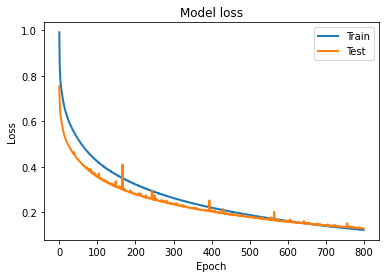

In [12]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [13]:
x_opt_predictions = autoencoder.predict(x_opt)

In [14]:
mse = np.mean(np.power(x_opt - x_opt_predictions, 2), axis=1)

In [15]:
mse.shape

(16516,)

In [16]:
mse

array([0.02056988, 0.00177151, 0.00126992, ..., 0.00121104, 0.00075146,
       0.01896406])

In [17]:
print(mse.mean())
print(mse.max())
print(mse.min())

0.1298300826338362
194.01755574096086
0.0002112179938006577


In [18]:
tr = mse.mean() + mse.std()
tr

3.2590175667475196